C:\Users\Luana\AppData\Local\Temp\ipykernel_9240\3015373832.py:12: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('movies_metadata.csv')


   adult                              belongs_to_collection    budget  \
0  False                                                NaN  98000000   
1  False                                                NaN  52000000   
2  False                                                NaN   4000000   
3  False                                                NaN  18000000   
4  False                                                NaN         0   
5  False                                                NaN    900000   
6  False                                                NaN  25000000   
7  False                                                NaN  55000000   
8  False  {'id': 217704, 'name': 'The Vampire Chronicles...  60000000   
9  False  {'id': 10, 'name': 'Star Wars Collection', 'po...  11000000   

                                              genres  \
0  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
1  [{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...   
2  [{'id': 80, 'name': 'Crim

c:\Users\Luana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


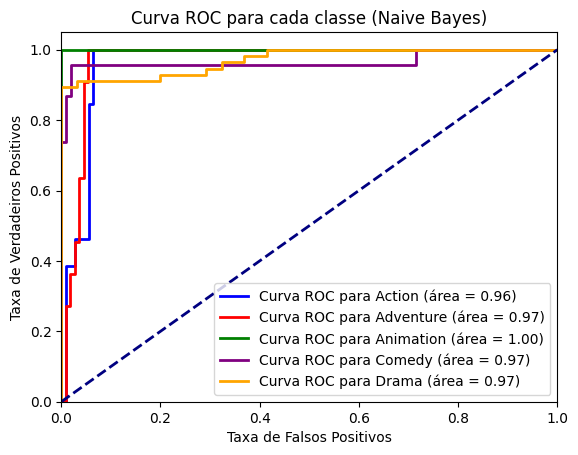

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score, roc_curve, auc, accuracy_score, classification_report
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB

# Carregue o conjunto de dados
df = pd.read_csv('movies_metadata.csv')
ratings_df = pd.read_csv('ratings_small.csv')

# Verifique a estrutura dos dados
#print(df.head(10))
#print(ratings_df.head(10))

# Engenharia de Recursos: Calcula a média das classificações de usuários por filme
average_ratings = ratings_df.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()
average_ratings.rename(columns={'mean': 'average_rating', 'count': 'num_ratings'}, inplace=True)

# Filtrar os filmes com pelo menos 20 avaliações
average_ratings = average_ratings[average_ratings['num_ratings'] >= 20]

# Remover entradas que não são convertíveis em inteiros
df = df[df['id'].str.isnumeric()]

# Converter a coluna 'id' para int64
df['id'] = df['id'].astype('int64')

# Combinar os dados de filmes com as médias das avaliações
df = df.merge(average_ratings, left_on='id', right_on='movieId', how='inner')


# Função para atribuir rótulos com base nos gêneros
def assign_genre_labels(genres):
    target_genres = ['Action', 'Adventure', 'Animation', 'Comedy', 'Drama']
    
    genre_list = eval(genres)  # Converte a string de gêneros em uma lista de dicionários
    
    # Cria uma lista com os gêneros presentes no filme
    labels = [genre['name'] for genre in genre_list if genre['name'] in target_genres]
    
    return labels

# Aplicar a função para obter as labels em formato de lista
df['label'] = df['genres'].apply(assign_genre_labels)

# Converter a lista de listas em uma matriz binária
mlb = MultiLabelBinarizer()
X = mlb.fit_transform(df['label'])

# Definir os nomes das colunas
genre_keywords = ['Action', 'Adventure', 'Animation', 'Comedy', 'Drama']

# Criar um DataFrame
X_df = pd.DataFrame(X, columns=genre_keywords)

# Concatenar com a coluna de avaliação média
X_combined = pd.concat([X_df, df['average_rating']], axis=1)
# print(X_combined.head(10))
# print(df['label'].head(10))

# Função para atribuir rótulos com base nos gêneros
def assign_genre_label(genres):
    target_genres = ['Action', 'Adventure', 'Animation', 'Comedy', 'Drama']
    
    genre_list = eval(genres)  # Converte a string de gêneros em uma lista de dicionários
    
    for genre in genre_list:
        if genre['name'] in target_genres:
            return genre['name']
    
    return 'Other'
    
# Atribuir rótulos aos filmes com base em gêneros
df['label'] = df['genres'].apply(assign_genre_label)
print(df.head(10))
    
# Dividir os Dados em Conjunto de Treinamento e Teste
X_train, X_test, y_train, y_test = train_test_split(X_combined, df['label'], test_size=0.2, random_state=42)

# print(train_test_split(X_combined, df['label'], test_size=0.2, random_state=42))
print(X_train)
print(y_train)
# Treinar o modelo Naive Bayes
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train, y_train)

# Acurácia do Modelo
accuracy = naive_bayes_model.score(X_test, y_test)
print(f'Acurácia do Modelo: {accuracy:.2f}')

# Criar um vetorizador de gêneros
vectorizer = CountVectorizer(vocabulary=genre_keywords)

# Fazer uma previsão
sample_genre_vector = mlb.transform([['Action', 'Adventure', 'Animation']])  # Gêneros do exemplo
sample_genre_vector_with_rating = np.append(sample_genre_vector, [[3.5]], axis=1)  # Adicionar a avaliação média

predicted_genre = naive_bayes_model.predict(sample_genre_vector_with_rating)
print(f'Gênero Previsto: {predicted_genre[0]}')

# Recomendar filmes com base no gênero previsto
recommended_movies = df[df['label'] == predicted_genre[0]].head(10)
print('Filmes Recomendados:')
print(recommended_movies[['title', 'genres']])

# Fazer previsões no conjunto de teste
y_pred = naive_bayes_model.predict(X_test)

# Calcular precisão, revocação, F1 e suporte para cada gênero
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None, labels=genre_keywords)

# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred)

# Imprimir as métricas para cada gênero
print('Métricas para cada gênero:')
for i, genre in enumerate(genre_keywords):
    print(f'Gênero: {genre}')
    print(f'  Precisão: {precision[i]:.2f}')
    print(f'  Revocação: {recall[i]:.2f}')
    print(f'  F1: {f1[i]:.2f}')
    print(f'  Suporte: {support[i]}')
    print()

# Calcular a curva ROC para cada classe (one-vs-rest)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(genre_keywords)):
    y_test_binary = y_test.apply(lambda x: 1 if x == genre_keywords[i] else 0)
    y_score = naive_bayes_model.predict_proba(X_test)[:, i]
    fpr[i], tpr[i], _ = roc_curve(y_test_binary, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotar a curva ROC para cada classe
plt.figure()
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i in range(len(genre_keywords)):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Curva ROC para {genre_keywords[i]} (área = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC para cada classe (Naive Bayes)')
plt.legend(loc='lower right')
plt.show()
